# 电路 (Circuit)

## 构建电路

Cirq的核心功能是构建量子电路。以下是实现这一目标所需的方法和数据结构.

### 电路构建
构成电路的核心数据结构及其使用方法。包括**电路(Circuits)**、**量子比特(Qubits)**、**门和操作(Gates and Operations)**、**自定义门(Custom gates)**、**导入/导出电路(Import/Export circuits)**。

### 高级构建
构建量子电路的更复杂方法。包括**操作符(Operators)**、**可观测量(Observables)和Pauli字符串(PauliStrings)**,**协议(Protocols)**和**工具生态系统(Tools ecosystem)**.

# 电路

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    import cirq

    print("installed cirq.")

## 概念概述
在Cirq中，量子程序的主要表示是Circuit类。一个Circuit是多个Moments的集合。一个Moment是同时作用于同一抽象时间片的多个Operations的集合。一个Operation是作用于特定子集量子比特的效果；最常见的Operation类型是GateOperation。

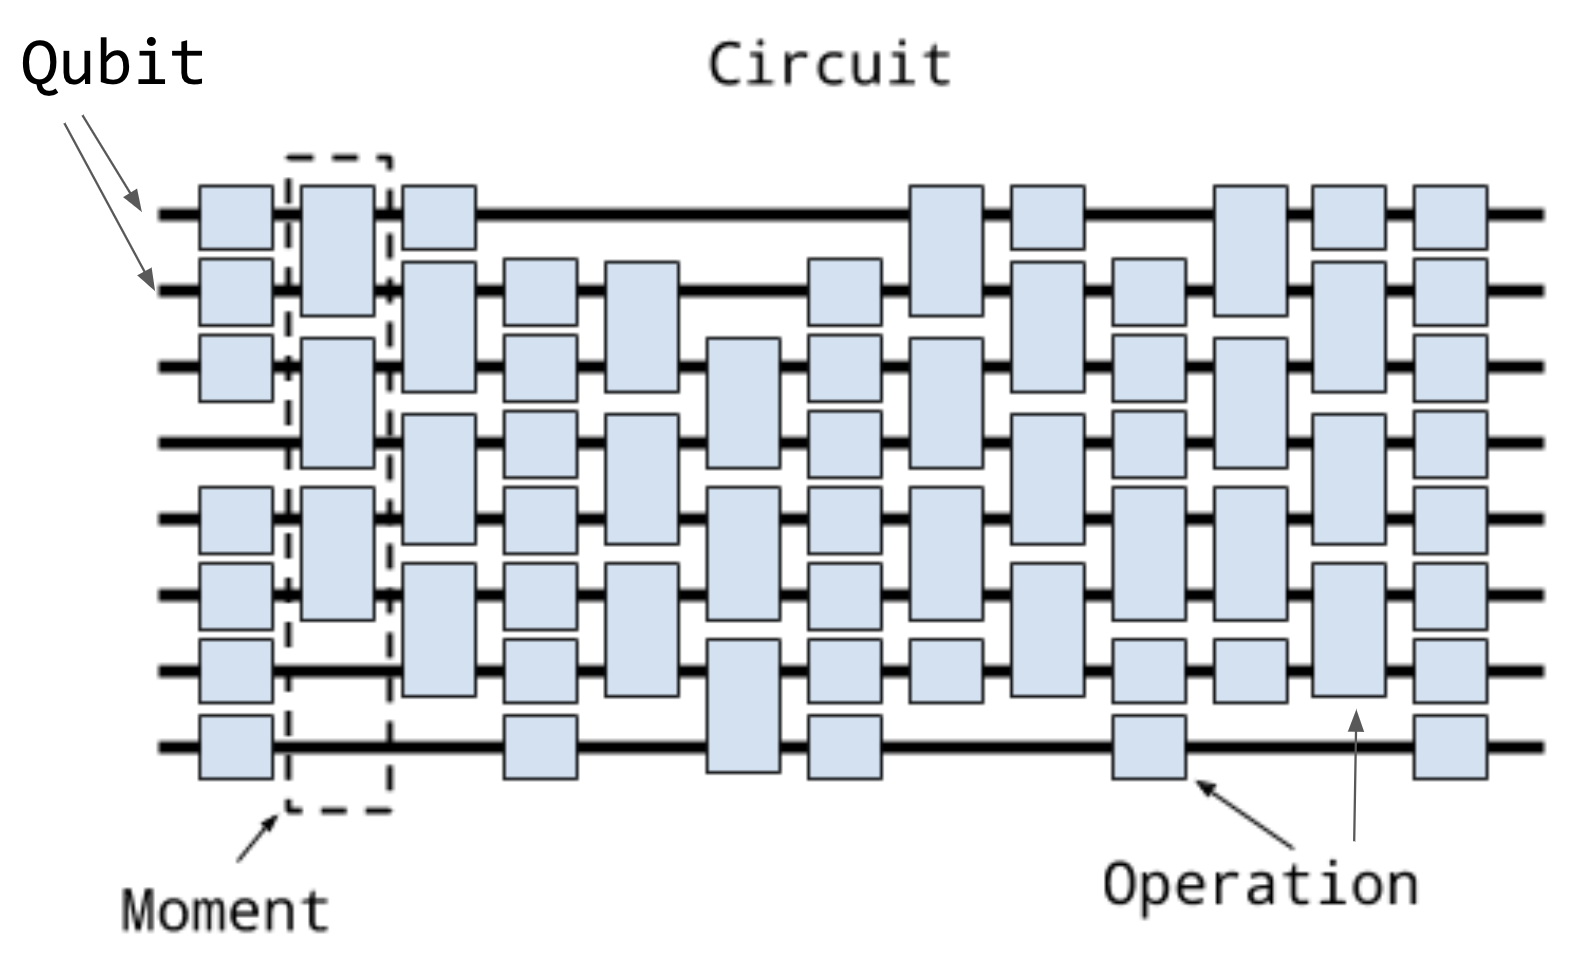
*图1：Cirq电路的概念图示, 引用自：https://quantumai.google/cirq/build/circuits*


让我们来解读一下。

在这个构建的基础是量子比特的概念。在Cirq中，量子比特和其他量子对象由cirq.Qid基类的子类实例标识。不同的Qid子类可以用于不同的目的。例如，Google设备使用的量子比特通常排列在方形网格的顶点上。为此，类cirq.GridQubit继承了cirq.Qid。例如，你可以使用以下代码创建一个3x3的量子比特网格：


In [2]:
qubits = cirq.GridQubit.square(3)

print(qubits[0])
print(qubits)

q(0, 0)
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2)]


下一个层级是cirq.Gate的概念。cirq.Gate表示在量子比特上发生的物理过程。门的重要属性是它可以应用于一个或多个量子比特。这可以通过```gate.on(*qubits)```方法或通过```gate(*qubits)```来完成。这样做会将一个cirq.Gate转换为一个cirq.Operation。


In [3]:
#以下是一个Pauli X门的例子
x_gate = cirq.X
#将其应用在第一个量子比特上，得到一个操作
x_op = x_gate(qubits[0])
print(x_op)

X(q(0, 0))


cirq.Moment只是操作的集合，每个操作作用于不同的量子比特集合，并且概念上表示这些操作在同一抽象时间片内发生。Moment结构本身不需要与量子计算机或模拟器上操作的实际调度相关，但它可以是。例如，下面是一个Moment，其中Pauli X和CZ门作用于三个量子比特：

In [4]:
cz = cirq.CZ(qubits[0], qubits[1])
x = cirq.X(qubits[2])
#将两个操作放在一个瞬间里
moment = cirq.Moment([x, cz])
print(moment)

  ╷ 0 1 2
╶─┼───────
0 │ @─@ X
  │


上述方法并不是构建Moments的唯一方法，甚至不是典型方法，但它说明了Moment只是作用于不相交量子比特集合的操作的集合。  

最后，在顶层，cirq.Circuit是一个有序的cirq.Moment对象系列。这个系列中的第一个Moment包含将要应用的第一个操作。例如，下面是一个由两个Moments组成的简单电路：

In [5]:
cz01 = cirq.CZ(qubits[0], qubits[1])
x2 = cirq.X(qubits[2])
cz12 = cirq.CZ(qubits[1], qubits[2])
#将三个操作放在两个瞬间里
moment0 = cirq.Moment([cz01, x2])
moment1 = cirq.Moment([cz12])
#将两个瞬间放在一个电路里
circuit = cirq.Circuit((moment0, moment1))
print(circuit)

(0, 0): ───@───────
           │
(0, 1): ───@───@───
               │
(0, 2): ───X───@───


请注意，上述方法是构建电路的众多方法之一，它说明了电路```circuit```是瞬间```moment```对象的可迭代集合的概念。


## 构建电路
将电路构建为一系列手动定义的```Moment```对象很繁琐。但Cirq提供了多种不同的方法来创建电路。

构建电路最有用的方法之一是使用```Circuit.append```方法将操作附加到电路上。


In [6]:
q0, q1, q2 = [cirq.GridQubit(i, 0) for i in range(3)]
circuit = cirq.Circuit()
circuit.append([cirq.CZ(q0, q1), cirq.H(q2)])
print(circuit)

(0, 0): ───@───
           │
(1, 0): ───@───

(2, 0): ───H───


这会给量子比特添加一个新瞬间```moment```，并可以继续添加

In [7]:
circuit.append([cirq.H(q0),cirq.CZ(q1, q2)])
print(circuit)

(0, 0): ───@───H───
           │
(1, 0): ───@───@───
               │
(2, 0): ───H───@───


通过这两个示例，我们添加了所有的Moments。那么，当一次性附加所有这些操作时会发生什么？


In [8]:
circuit = cirq.Circuit()
circuit.append([cirq.CZ(q0,q1),cirq.H(q2), cirq.H(q0), cirq.CZ(q1, q2)])
print(circuit)

(0, 0): ───@───H───
           │
(1, 0): ───@───@───
               │
(2, 0): ───H───@───


这再次创建了两个Moment对象。Circuit是如何知道该怎么做的呢？Circuit.append方法（及其类似方法Circuit.insert）都接受一个名为strategy的参数，该参数的类型为cirq.InsertStrategy。默认情况下，InsertStrategy是InsertStrategy.EARLIEST。


### 插入策略 InsertStrategy

```cirq.InsertStrategy```定义了在请求插入到给定位置时，操作如何放置在电路中。这里的位置由请求插入的Moment（在电路中的索引）标识（在Circuit.append的情况下，这意味着插入到电路中最大Moment索引加一的位置）。

有四种这样的策略：```InsertStrategy.EARLIEST```、```InsertStrategy.NEW```、```InsertStrategy.INLINE```和```InsertStrategy.NEW_THEN_INLINE```。

```InsertStrategy.EARLIEST```是默认策略，其定义如下：

从插入位置向后扫描，直到找到一个包含触及要插入操作的量子比特的Moment。操作被添加到该位置之后的Moment中。

例如，如果你首先在一个Moment中创建一个操作，然后使用```InsertStrategy.EARLIEST```，操作可以回滑到这个第一个Moment中，如果那里有空间的话：


In [9]:
from cirq.circuits import InsertStrategy
circuit = cirq.Circuit()
circuit.append([cirq.CZ(q0, q1)])
circuit.append([cirq.H(q0), cirq.H(q2)], strategy=InsertStrategy.EARLIEST)
print(circuit)  

(0, 0): ───@───H───
           │
(1, 0): ───@───────

(2, 0): ───H───────


在使用CZ门创建第一个Moment之后，第二次append使用了```InsertStrategy.EARLIEST```策略。q0上的H门不能回滑，而q2上的H门可以，因此最终出现在第一个Moment中。

与此形成对比的是```InsertStrategy.NEW```，其定义如下：

每个插入的操作都会在一个新的Moment中创建。

In [10]:
circuit = cirq.Circuit()
circuit.append([cirq.H(q0), cirq.H(q1), cirq.H(q2)], strategy= InsertStrategy.NEW)

print(circuit)

(0, 0): ───H───────────

(1, 0): ───────H───────

(2, 0): ───────────H───


在这里，每个由append处理的操作最终都会出现在一个新的Moment中。```InsertStrategy.NEW```使用情景：插入单个操作且不希望它干扰其他Moments。

另一种策略是```InsertStrategy.INLINE```：

尝试将要插入的操作添加到所需插入位置之前的Moment中。但是，如果已经存在影响要插入操作所触及的任何量子比特的操作，则会创建一个新的Moment。


In [11]:
circuit = cirq.Circuit()
circuit.append([cirq.CZ(q1,q2)])
circuit.append([cirq.CZ(q1,q2)])
circuit.append([cirq.H(q0), cirq.H(q1), cirq.H(q2)], strategy=InsertStrategy.INLINE)
print(circuit)

(0, 0): ───────H───────

(1, 0): ───@───@───H───
           │   │
(2, 0): ───@───@───H───


在第二和第三个量子比特之间进行两个初始CZ操作之后，示例插入了三个H操作。第一个量子比特上的H操作被插入到前一个Moment中，但第二和第三个量子比特上的H操作不能插入到前一个Moment中，因此创建了一个新的Moment。

最后，```InsertStrategy.NEW_THEN_INLINE```策略，用于开始一个新的Moment，然后从该点继续插入操作。

在所需插入位置为第一个操作创建一个新的Moment，但随后切换到根据InsertStrategy.INLINE插入操作。

In [13]:
circuit = cirq.Circuit()
circuit.append([cirq.H(q0)])
circuit.append([cirq.CZ(q1, q2), cirq.H(q0)], strategy=InsertStrategy.NEW_THEN_INLINE)
print(circuit)

(0, 0): ───H───H───

(1, 0): ───────@───
               │
(2, 0): ───────@───


第一次append在第一个量子比特上创建了一个包含H操作的Moment。然后，使用```InsertStrategy.NEW_THEN_INLINE```策略的append首先在一个新的Moment中插入CZ操作（```InsertStrategy.NEW_THEN_INLINE```中的```InsertStrategy.NEW```）。随后的append操作使用```InsertStrategy.INLINE```，因此下一个在第一个量子比特上的H操作被append到刚创建的Moment中。

下面是一个图示，展示了使用不同策略append 1和2的简单示例：  
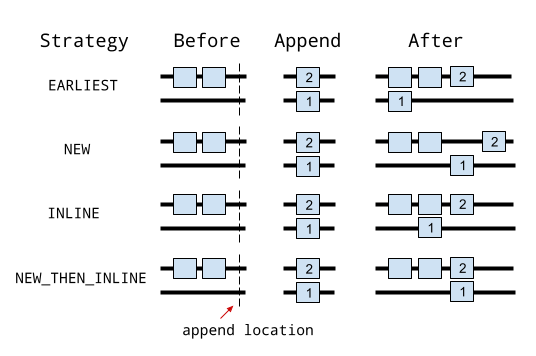
*图2：不同策略添加1和2操作, 引用自：https://quantumai.google/cirq/build/circuits*

### 添加（append）和插入（insert）的参数模式

在上述示例中，使用了一系列```Circuit.append```调用，并将不同的操作添加到电路中。然而，提供列表的参数也可以接受不只是列表的值。例如：


In [14]:
def my_layer():
    yield cirq.CZ(q0,q1)
    yield[cirq.H(q) for q in (q0, q1, q2)]
    yield [cirq.CZ(q1, q2)]
    yield [cirq.H(q0), [cirq.CZ(q1, q2)]]

circuit = cirq.Circuit()
circuit.append(my_layer())

for x in my_layer():
    print(x)

CZ(q(0, 0), q(1, 0))
[cirq.H(cirq.GridQubit(0, 0)), cirq.H(cirq.GridQubit(1, 0)), cirq.H(cirq.GridQubit(2, 0))]
[cirq.CZ(cirq.GridQubit(1, 0), cirq.GridQubit(2, 0))]
[cirq.H(cirq.GridQubit(0, 0)), [cirq.CZ(cirq.GridQubit(1, 0), cirq.GridQubit(2, 0))]]


In [15]:
print(circuit)

(0, 0): ───@───H───H───────
           │
(1, 0): ───@───H───@───@───
                   │   │
(2, 0): ───H───────@───@───


回顾一下，包含yield的Python函数是生成器。生成器是充当迭代器的函数。上面的示例使用for循环迭代my_layer()。在这种情况下，每个yield会产生：

- 操作（Operations）
- 操作列表（lists of Operations）
- 或混合了操作列表的操作列表（lists of Operations mixed with lists of Operations）

当你将一个迭代器传递给append方法时，Circuit能够将所有这些展平并作为一个巨大的列表传递给```Circuit.append```（这也适用于```Circuit.insert```）。

上述思想使用了```cirq.OP_TREE```的概念。```OP_TREE```不是一个类，而是一种约定。基本思想是，如果输入可以迭代地展平成一个操作列表，那么该输入就是一个```OP_TREE```。

从这种结构中出现了一个非常好的模式：为子电路定义生成器，这些子电路可以根据大小或操作参数变化。

另一种从OP_TREE完全构建电路的有用方法是，在初始化Circuit时将OP_TREE传递给它：
